Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

Use NSE custom objective.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190909-184940'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    #'max_depth': sp.stats.randint(2, 8),
    #'learning_rate': sp.stats.uniform(0.005, 0.1),
    #'gamma': sp.stats.uniform(0, 5),
    #'min_child_weight': sp.stats.randint(1, 30),
    'subsample': sp.stats.uniform(0.5, 0.5),
    #'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    #'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    #'reg_alpha': sp.stats.expon(0, 20),
    #'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
class NSEObjective:
    """Custom NSE XGBoost objective.
    
    This is a bit of a hack: We use a unique dummy target value for each sample, allowing us to look up
    the mean that corresponds to the sample's station.
    When calculating the loss, we replace the dummy with the actual target, so the model learns the right thing.
    """
    def __init__(self, dummy_target, actual_target, means, stations):
        self.dummy_target = dummy_target.to_numpy()
        self.actual_target = actual_target.to_numpy()
        self.means = means.to_numpy()
        self.stations = stations.to_numpy()
        
    def nse_objective(self, y_true, y_pred):
        """ NSE objective for XGBoost, slightly modified to normalize with mean """
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        means = self.means[indices]
        stations = self.stations[indices]
        grad, hess = np.empty(len(y_pred)), np.empty(len(y_pred))
        for station in np.unique(stations):
            station_mask = stations == station
            # normalize with mean instead of sum, because otherwise the gradients would be too small.
            normalization = np.mean(np.square(actual_target[station_mask] - means[station_mask]))
            grad[station_mask] = 2 * (y_pred[station_mask] - actual_target[station_mask]) / normalization
            hess[station_mask] = 2.0 / normalization
        return grad, hess
    
    def nse(self, y_pred, y_true, means):
        return np.sum(np.square(y_pred - y_true)) / np.sum(np.square(y_true - means))
    
    def nse_metric(self, y_pred, y_true):
        """ NSE metric for XGBoost """
        indices = np.searchsorted(self.dummy_target, y_true.get_label())
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return 'nse', nse / len(unique_stations)
    
    def neg_nse_metric_sklearn(self, estimator, X, y_true):
        """ -NSE metric for sklearn """
        y_pred = estimator.predict(X)
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return -nse / len(unique_stations)

In [5]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

data['dummy_target'] = range(len(data))
means = data.groupby('station')['runoff'].mean()
data = data.join(means, on='station', rsuffix='_mean')
nse_loss = NSEObjective(data['dummy_target'], data['runoff'], data['runoff_mean'], data['station'])

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target']), 
       (val.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), val['dummy_target'])]

m = xgb.XGBRegressor(n_estimators=10000, learning_rate=0.08123625637629309, reg_alpha=3.7125525377954642, reg_lambda=0.0182830417835344, colsample_bylevel=0.9237069325689322, colsample_bytree=0.4540275483264704, gamma=0.9980644706841152, max_depth=7, min_child_weight=1, subsample=0.4831765844168827, objective=nse_loss.nse_objective, n_jobs=-1, random_state=123)
#m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=20, cv=2, return_train_score=True, scoring=nse_loss.neg_nse_metric_sklearn, n_jobs=40, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target'], eval_set=val, 
              eval_metric=nse_loss.nse_metric, early_stopping_rounds=200, verbose=True)

#cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
#print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
#print('Best params: {}'.format(m.best_params_))
#print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8775), val (4897, 8775), test (33580, 8775)


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:47213	validation_1-rmse:47427.6	validation_0-nse:1.34437	validation_1-nse:1.3881
Multiple eval metrics have been passed: 'validation_1-nse' will be used for early stopping.

Will train until validation_1-nse hasn't improved in 200 rounds.
[1]	validation_0-rmse:47212.6	validation_1-rmse:47427.3	validation_0-nse:1.29015	validation_1-nse:1.32791
[2]	validation_0-rmse:47212.2	validation_1-rmse:47426.9	validation_0-nse:1.24872	validation_1-nse:1.27965
[3]	validation_0-rmse:47211.8	validation_1-rmse:47426.5	validation_0-nse:1.20632	validation_1-nse:1.22614
[4]	validation_0-rmse:47211.6	validation_1-rmse:47426.3	validation_0-nse:1.17067	validation_1-nse:1.18948
[5]	validation_0-rmse:47211.4	validation_1-rmse:47426	validation_0-nse:1.13756	validation_1-nse:1.15133
[6]	validation_0-rmse:47211.1	validation_1-rmse:47425.7	validation_0-nse:1.11044	validation_1-nse:1.12164
[7]	validation_0-rmse:47210.7	validation_1-rmse:47425.4	validation_0-nse:1.08853	validation_1-nse:1.09912

02GA010 	NSE: 0.3397853156778895 	MSE: 314.7728976635164 (clipped to 0)
02GA018 	NSE: 0.37234719155012663 	MSE: 157.63699909322204 (clipped to 0)
02GA038 	NSE: 0.3093283734783596 	MSE: 113.64204367248097 (clipped to 0)
02GA047 	NSE: 0.2768021399799684 	MSE: 56.69149808439722 (clipped to 0)
02GB001 	NSE: 0.14930183018789578 	MSE: 6388.637086968456 (clipped to 0)
02GB007 	NSE: 0.4498333791125415 	MSE: 17.20481856161061 (clipped to 0)
02GC002 	NSE: 0.48726994044952476 	MSE: 65.88736859338228 (clipped to 0)
02GC007 	NSE: 0.5197506176841323 	MSE: 14.465757078071233 (clipped to 0)
02GC010 	NSE: 0.5060287706260889 	MSE: 29.366549969227236 (clipped to 0)
02GC018 	NSE: 0.45021365563189675 	MSE: 37.23527073563772 (clipped to 0)
02GC026 	NSE: 0.5373912569456645 	MSE: 74.40263786532562 (clipped to 0)
02GD004 	NSE: 0.4733099394925201 	MSE: 29.00117346760505 (clipped to 0)
02GE007 	NSE: 0.43910846111547663 	MSE: 20.290284219876458 (clipped to 0)
02GG002 	NSE: 0.5350980261522338 	MSE: 112.12637206437

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04161820 	NSE: 0.4146722436593031 	MSE: 18.483508635840362 (clipped to 0)
04164000 	NSE: 0.45459134877578466 	MSE: 95.57051679428207 (clipped to 0)
04165500 	NSE: 0.49121408744196526 	MSE: 227.76255109581155 (clipped to 0)
04166100 	NSE: 0.5005870963511406 	MSE: 3.6623484848768797 (clipped to 0)
04166500 	NSE: 0.5730694168251524 	MSE: 14.75655349329093 (clipped to 0)
04174500 	NSE: 0.3992049921574685 	MSE: 56.81972921126842 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04176500 	NSE: 0.23370398031003936 	MSE: 523.4370531595883 (clipped to 0)
04177000 	NSE: 0.3410002666769233 	MSE: 17.759930658582405 (clipped to 0)
04193500 	NSE: -0.23246940933799398 	MSE: 87259.75763081854 (clipped to 0)
04195820 	NSE: -0.08689402753493392 	MSE: 1275.7900525567284 (clipped to 0)
04196800 	NSE: 0.2820146282591175 	MSE: 214.8560361658155 (clipped to 0)
04197100 	NSE: 0.432734244849852 	MSE: 58.18127734459116 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04198000 	NSE: 0.15500867466968393 	MSE: 6242.4236099972495 (clipped to 0)
04199000 	NSE: 0.29360427411016177 	MSE: 722.3626002495591 (clipped to 0)
04199500 	NSE: 0.3107891826970215 	MSE: 278.88786285625196 (clipped to 0)
04200500 	NSE: 0.22118894359669006 	MSE: 779.3600838585277 (clipped to 0)
04207200 	NSE: 0.4029039436894586 	MSE: 13.975804224938997 (clipped to 0)
04208504 	NSE: 0.3422370984310993 	MSE: 642.3243223496388 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04209000 	NSE: 0.4390740005219621 	MSE: 175.37688826705138 (clipped to 0)
04212100 	NSE: 0.3214542457670352 	MSE: 996.3257199108828 (clipped to 0)
04213000 	NSE: 0.38636792038871215 	MSE: 110.12808074802899 (clipped to 0)
04213500 	NSE: 0.3620019362651532 	MSE: 653.5759625571521 (clipped to 0)
04214500 	NSE: 0.5397134009608024 	MSE: 55.48160585864498 (clipped to 0)
04215000 	NSE: 0.4754547496747632 	MSE: 50.38404674501109 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215500 	NSE: 0.5151241356990806 	MSE: 87.56126506593526 (clipped to 0)
Median NSE (clipped to 0) 0.4343924974394233 / Min -0.23246940933799398 / Max 0.5985917240291561
Median MSE (clipped to 0) 87.64275170218221 / Min 3.6623484848768797 / Max 87259.75763081854


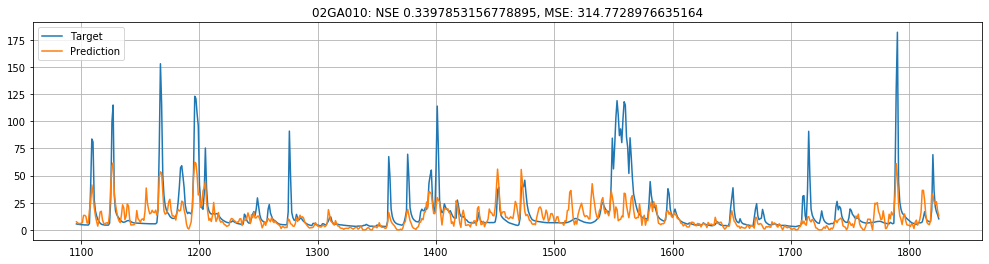

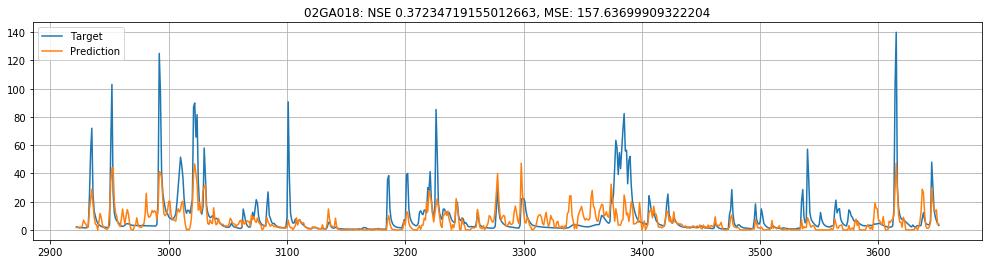

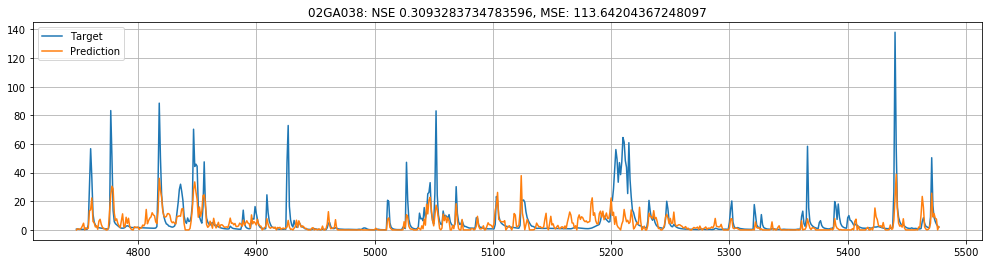

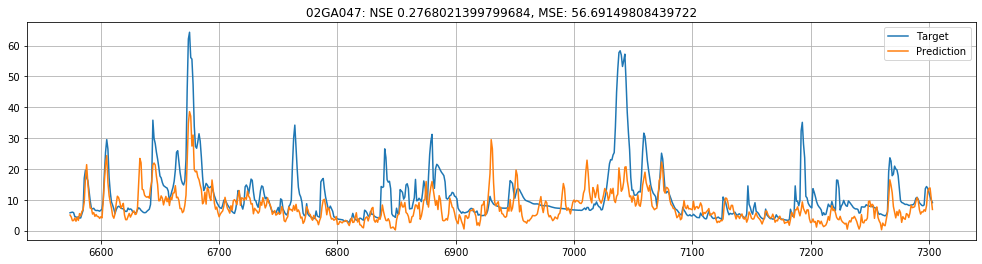

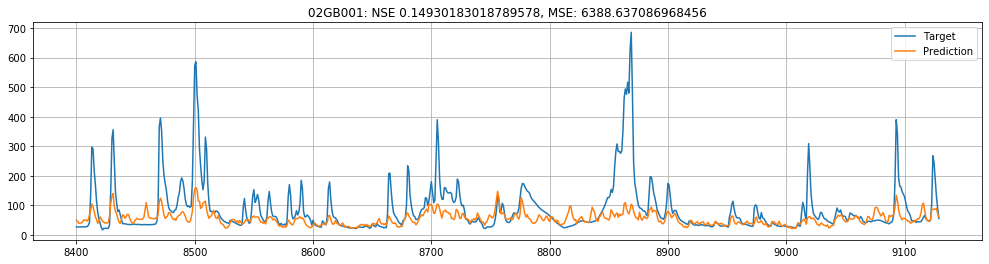

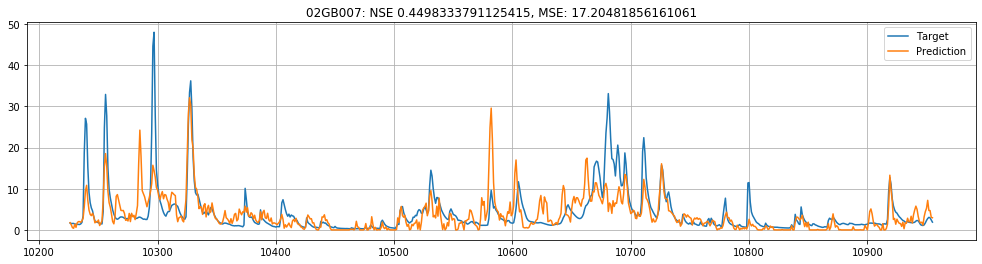

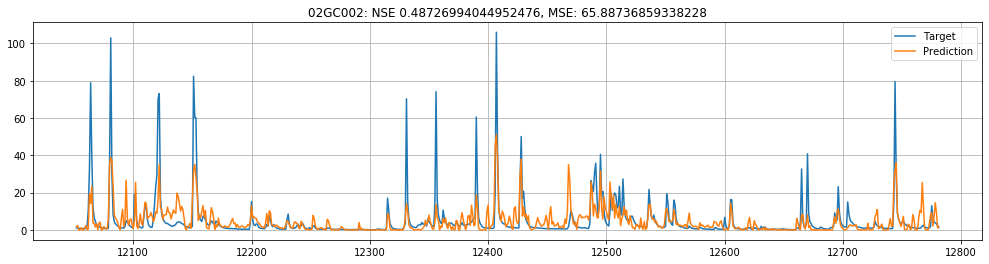

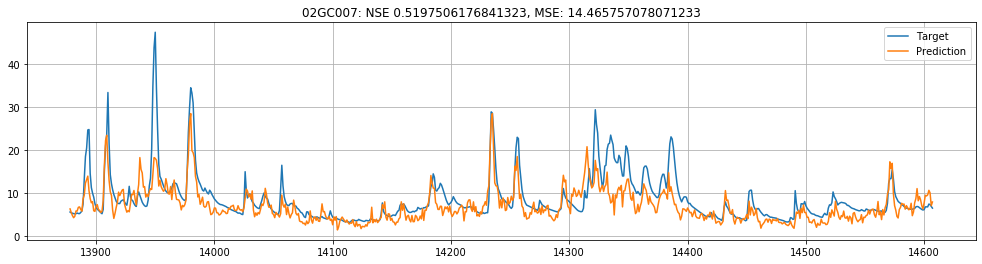

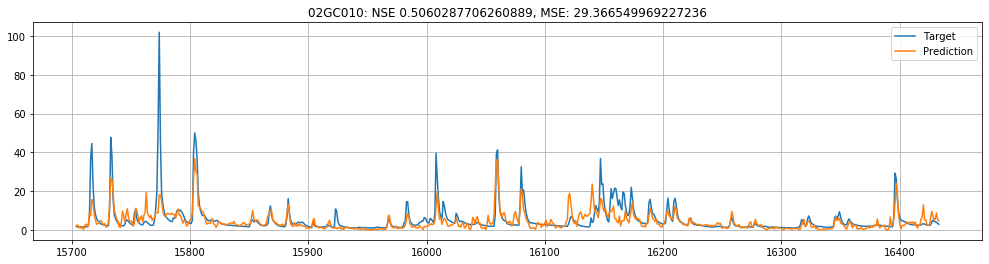

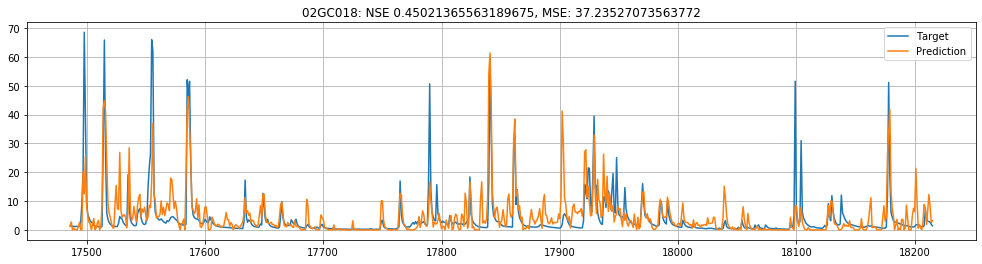

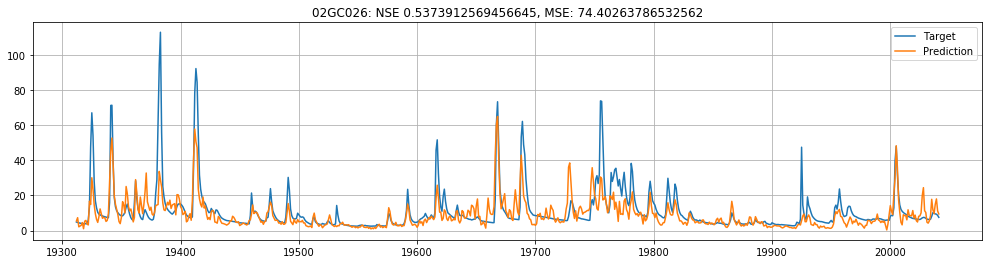

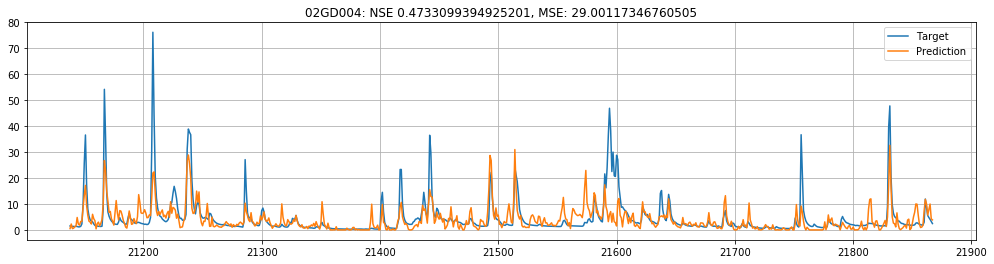

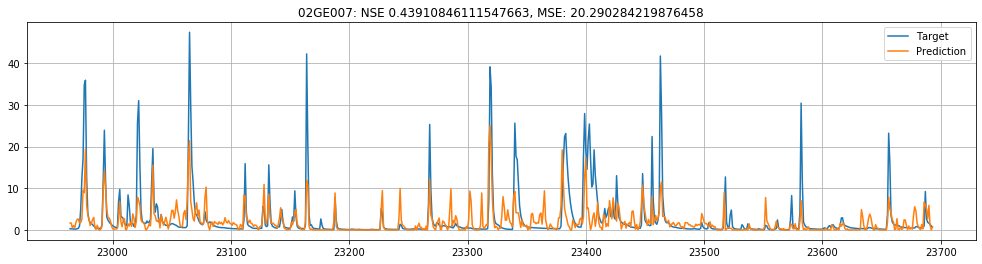

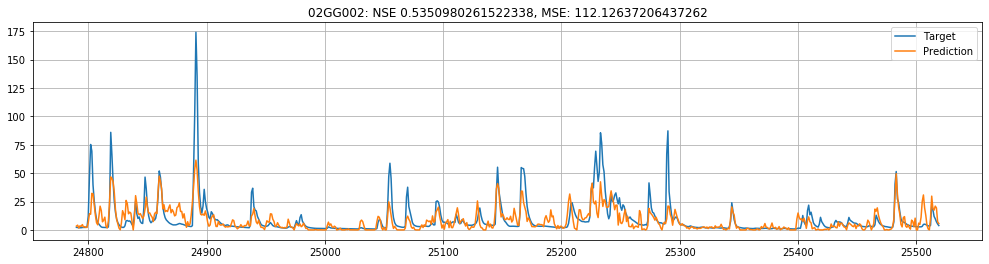

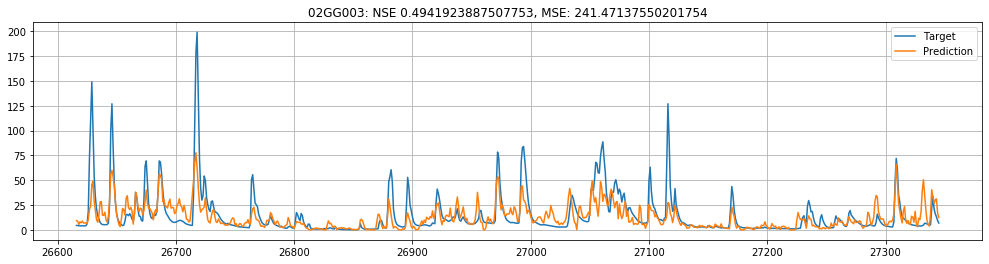

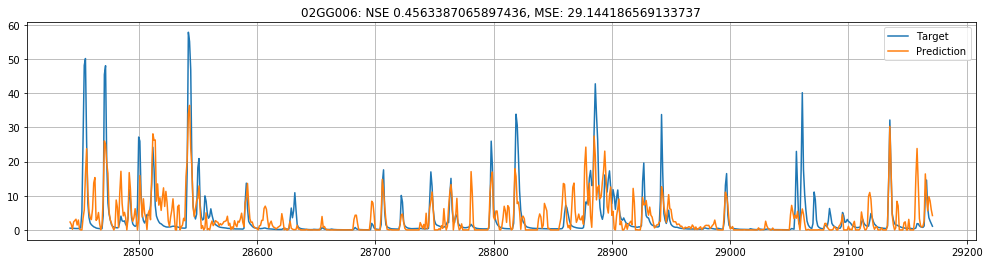

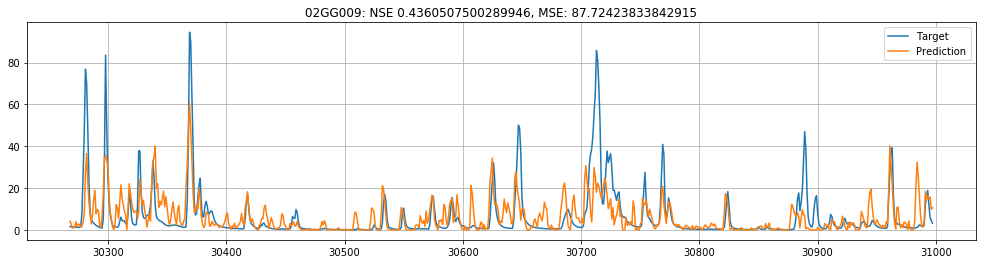

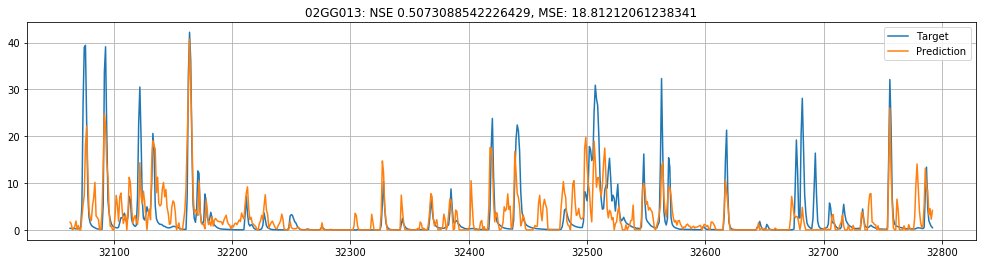

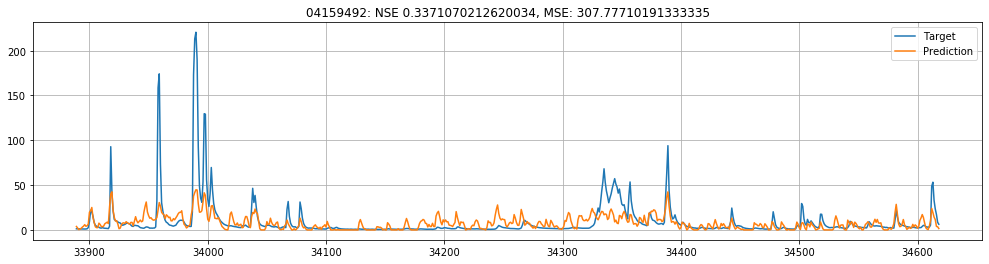

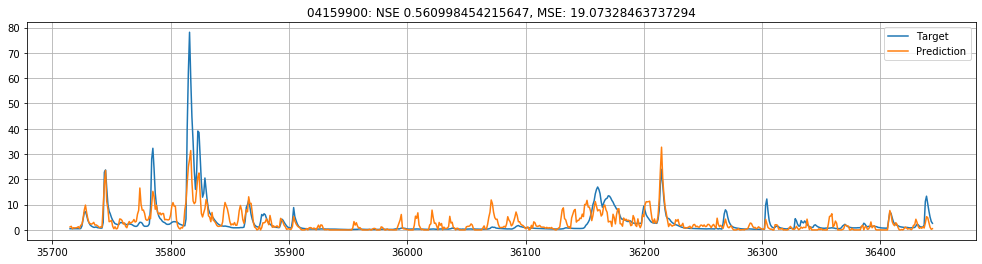

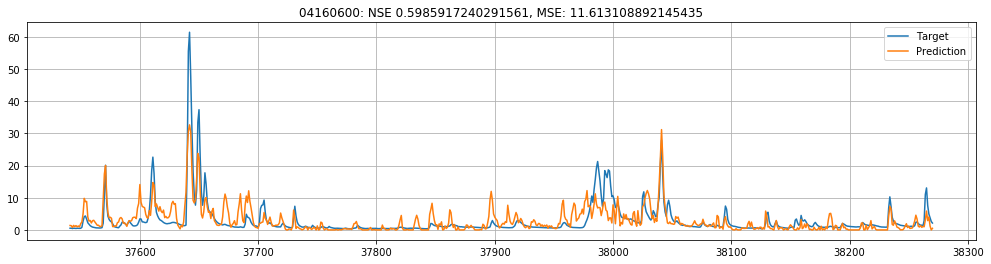

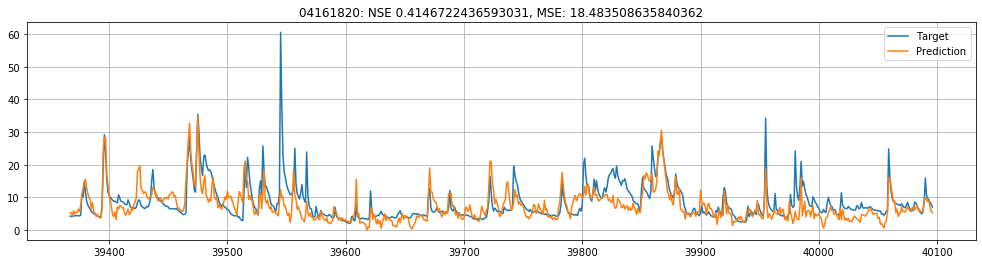

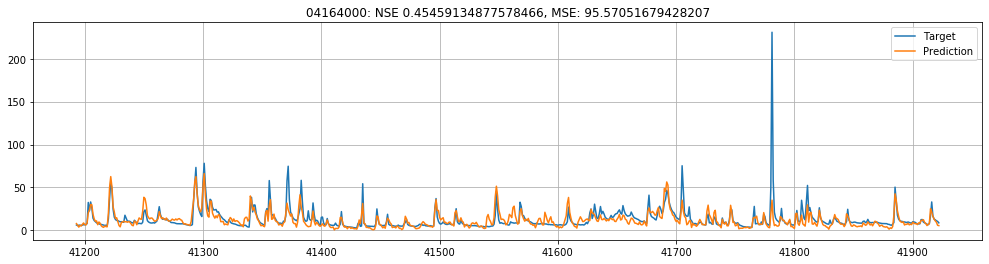

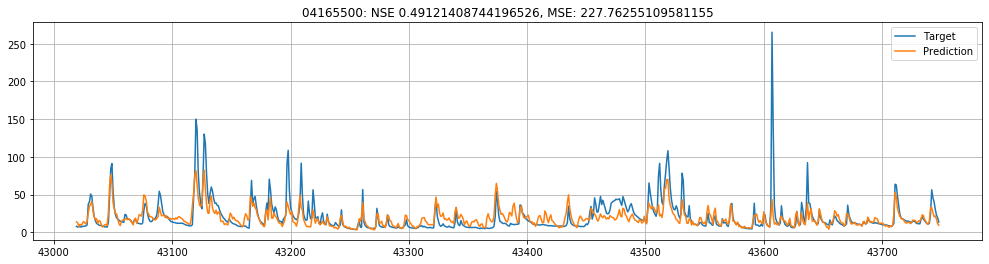

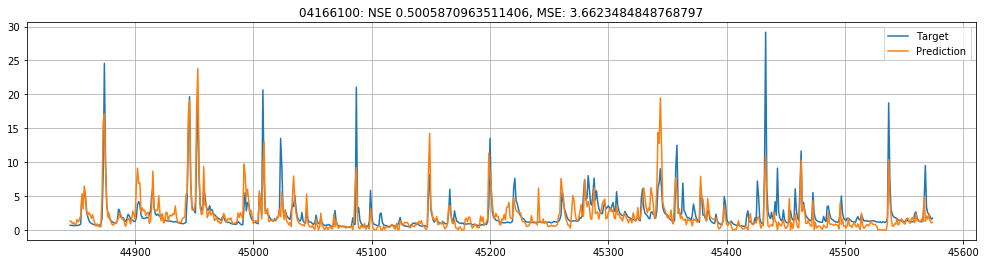

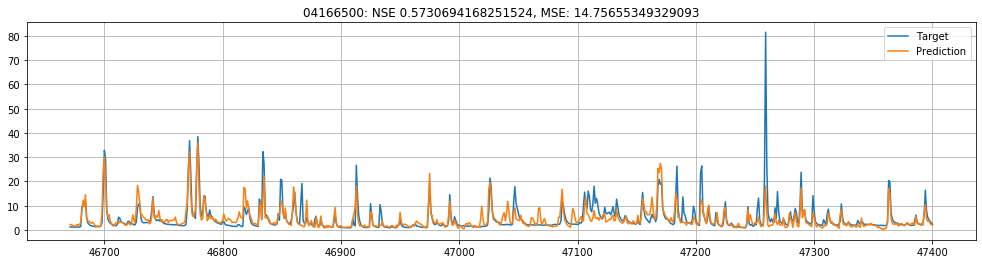

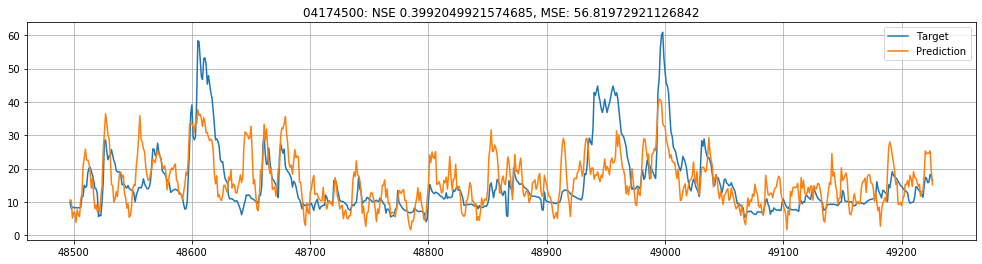

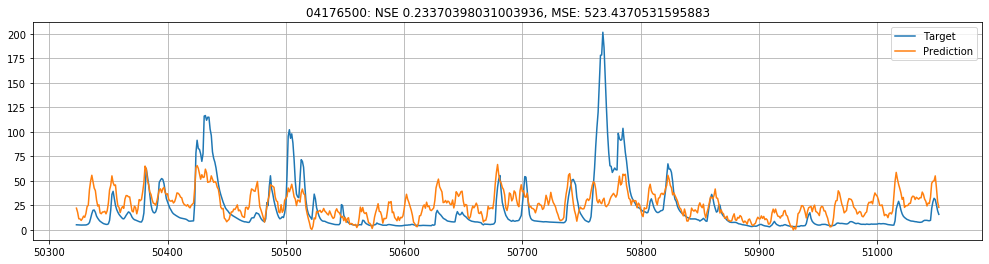

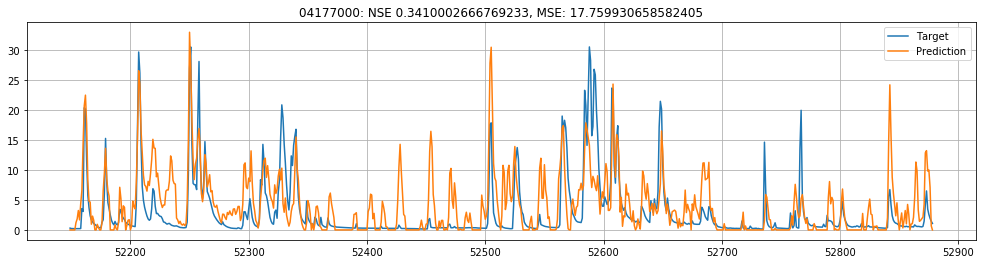

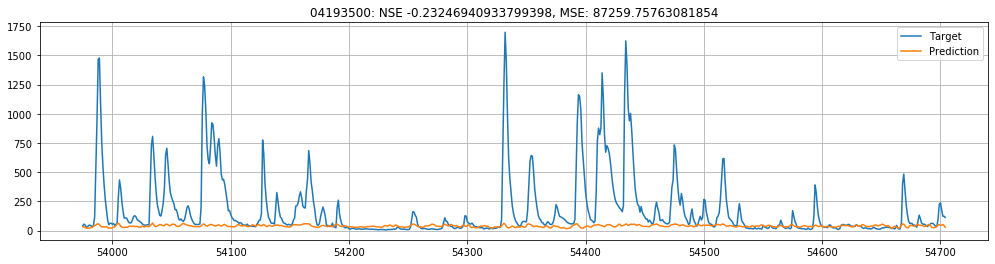

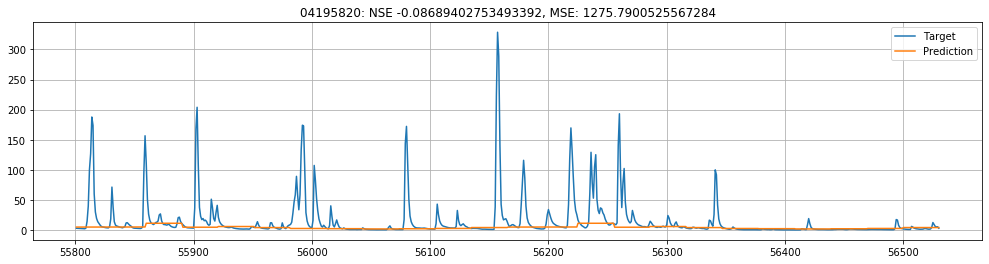

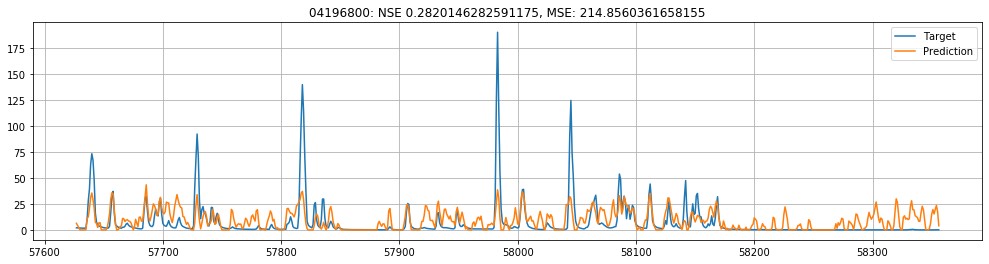

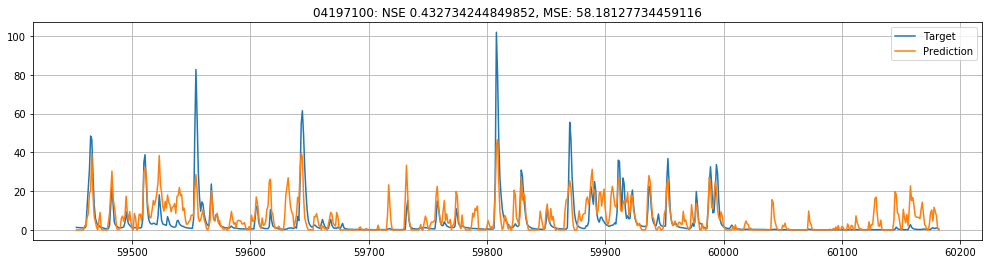

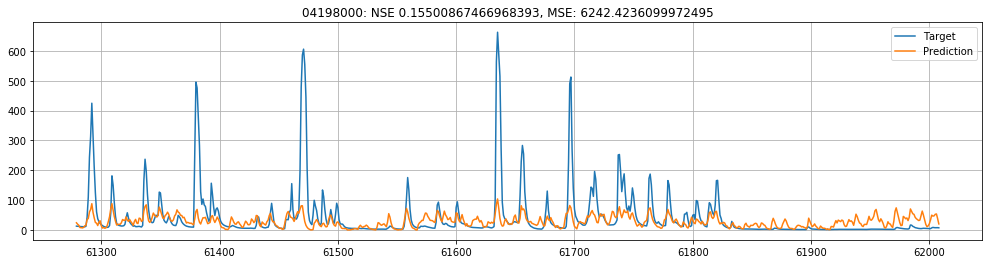

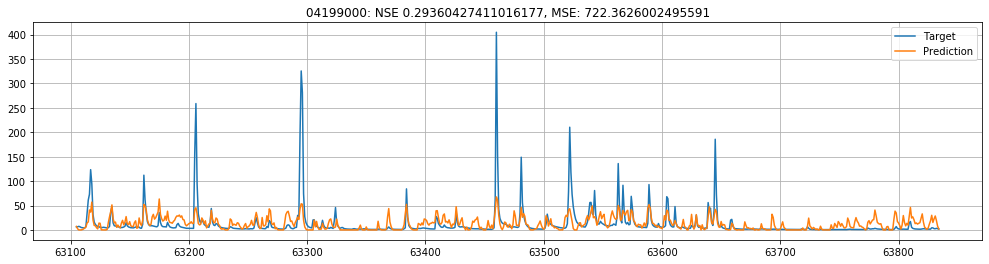

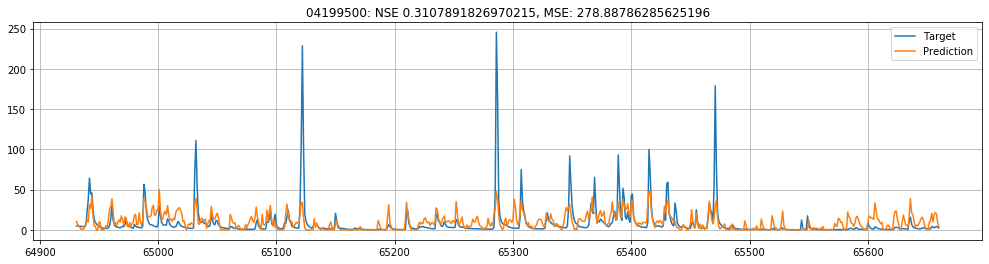

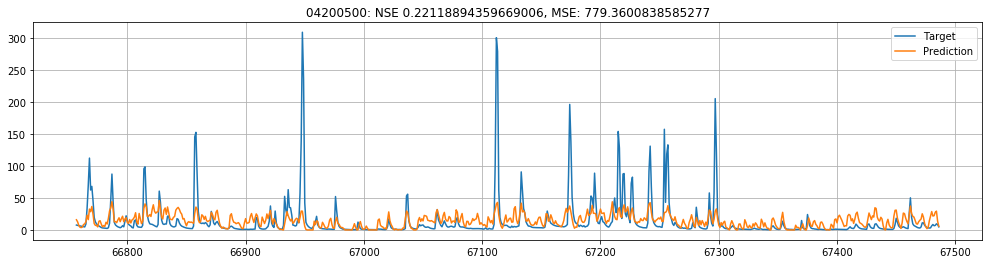

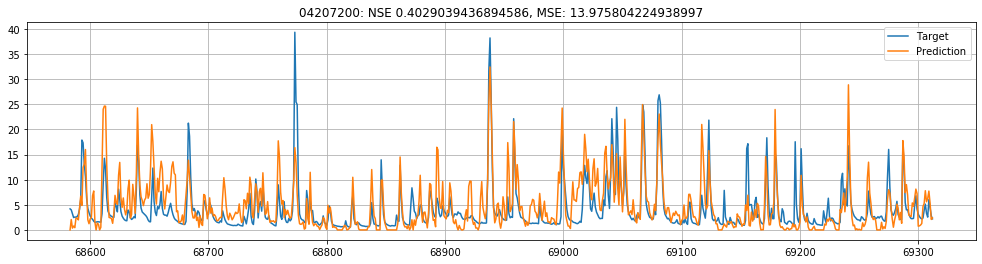

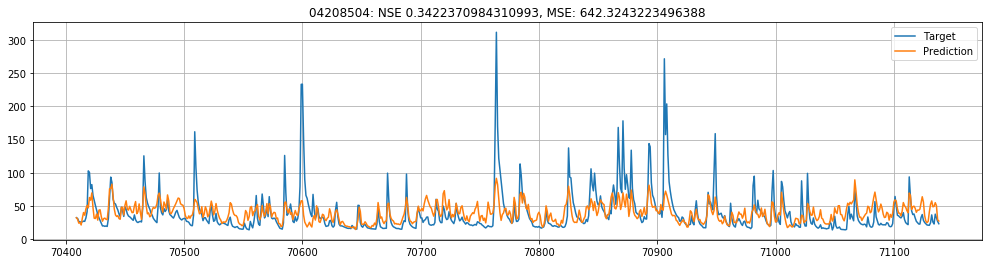

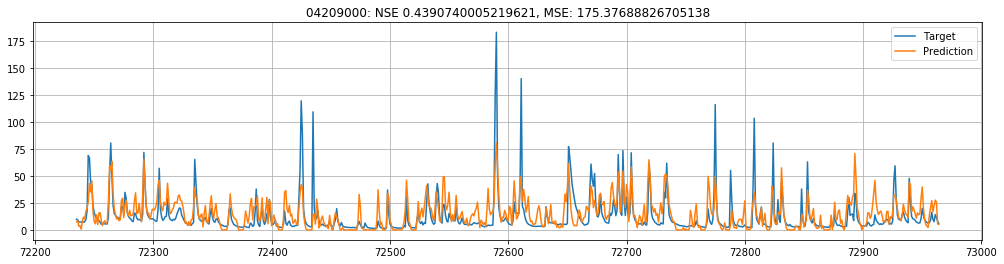

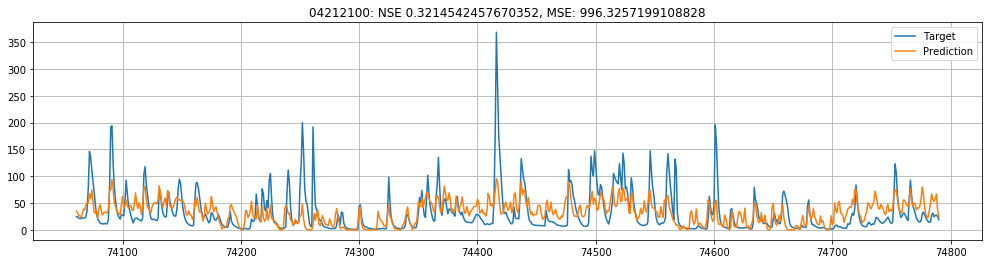

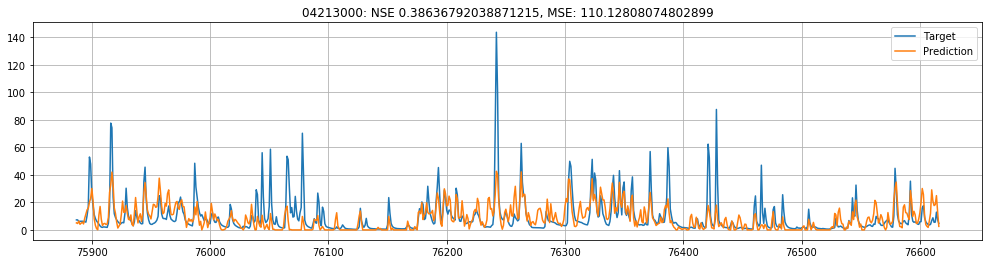

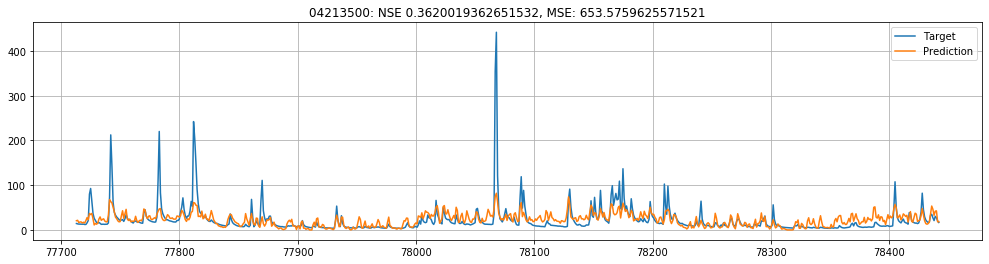

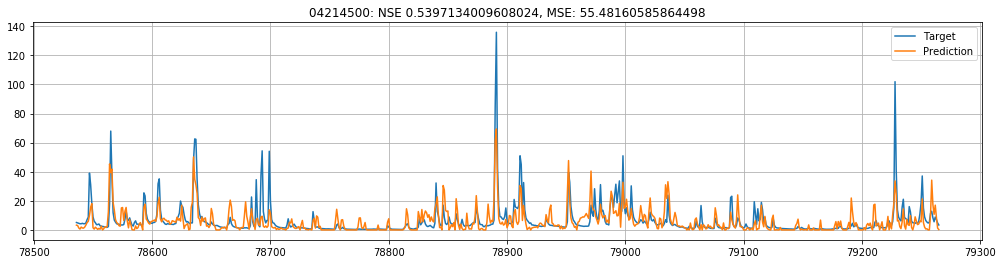

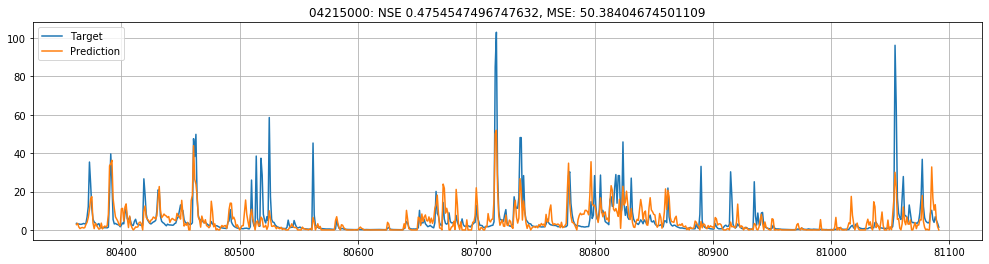

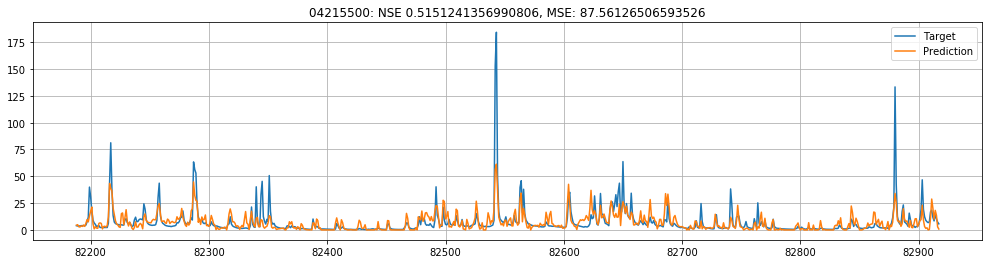

In [6]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [7]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel-NSELoss_20190909-184940.pkl'

In [8]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel-NSELoss_all_20190909-184940.pkl


In [9]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190909-191236'